# Imports and Functions

In [1]:
import math 
from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold_low
global threshold_high
threshold_low = -500
threshold_high = 0
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 0 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-512+(((x+5)*(512--512))/(51+5)))
def ynew(y): 
    return (-512+(((y+2)*(512--512))/(53+2)))

def eggholder(x):
       
    return (-(x[1]+47)*(math.sin(math.sqrt(abs((x[0]/2)+(x[1]+47))))))-((x[0])*(math.sin(math.sqrt(abs((x[0])+(x[1]+47))))))

def eggholderColor(x, threshold_low, threshold_high):
    
    if threshold_low < eggholder((xnew(x[0]),xnew(x[1]))) <threshold_high:
        return 1
    else:
        return 0

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zeggholder
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zeggholder = []
    eggholdercoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zeggholder.append(eggholderColor(eggholdercoords[i],threshold_low,threshold_high))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zeggholder)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

#     ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
#     plt.plot()
#     plt.show()
#     fig1.show()
    print('isolated', testpoints[ifinal])
#     return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[::5, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


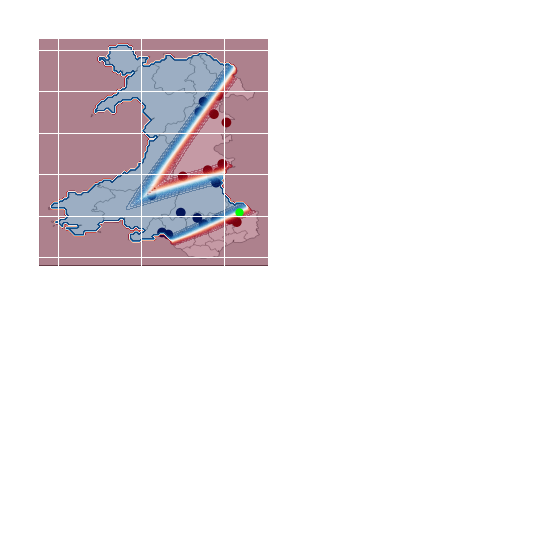

iteration  1
Accuracy is 0.50432609113632
iteration  2
Accuracy is 0.5062487983080177
iteration  3
Accuracy is 0.5056719861565083
iteration  4
Accuracy is 0.5093251297827341
iteration  5
Accuracy is 0.5247067871563161
iteration  6
Accuracy is 0.5112478369544319
iteration  7
Accuracy is 0.506825610459527
iteration  8
Accuracy is 0.5181695827725438
iteration  9
Accuracy is 0.5052874447221688
iteration  10
Accuracy is 0.5089405883483945
iteration  11
Accuracy is 0.5100942126514132
iteration  12
Accuracy is 0.5145164391463181
iteration  13
Accuracy is 0.5152855220149971
iteration  14
Accuracy is 0.5154777927321669
iteration  15
Accuracy is 0.5143241684291482
iteration  16
Accuracy is 0.5135550855604691
iteration  17
Accuracy is 0.5152855220149971
iteration  18
Accuracy is 0.5185541242068833
iteration  19
Accuracy is 0.517977312055374
iteration  20
Accuracy is 0.517977312055374
iteration  21
Accuracy is 0.5210536435300903
experiment:  1


<IPython.core.display.Javascript object>


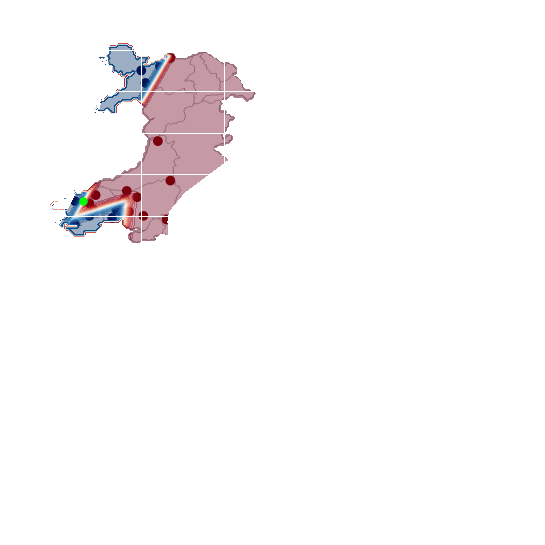

iteration  1
Accuracy is 0.5366275716208422
iteration  2
Accuracy is 0.549509709671217
iteration  3
Accuracy is 0.5331666987117862
iteration  4
Accuracy is 0.5356662180349933
iteration  5
Accuracy is 0.5420111517015959
iteration  6
Accuracy is 0.534128052297635
iteration  7
Accuracy is 0.5373966544895212
iteration  8
Accuracy is 0.534128052297635
iteration  9
Accuracy is 0.5304749086714093
iteration  10
Accuracy is 0.5379734666410305
iteration  11
Accuracy is 0.5412420688329167
iteration  12
Accuracy is 0.5464333781965006
iteration  13
Accuracy is 0.5389348202268794
iteration  14
Accuracy is 0.5397039030955586
iteration  15
Accuracy is 0.5420111517015959
iteration  16
Accuracy is 0.5448952124591425
iteration  17
Accuracy is 0.5379734666410305
iteration  18
Accuracy is 0.5441261295904634
iteration  19
Accuracy is 0.5420111517015959
iteration  20
Accuracy is 0.54701019034801
iteration  21
Accuracy is 0.5464333781965006
experiment:  2


<IPython.core.display.Javascript object>


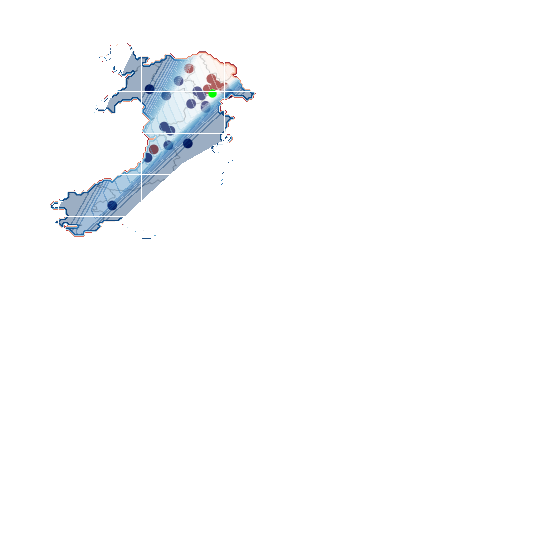

iteration  1
Accuracy is 0.4964429917323592
iteration  2
Accuracy is 0.49413574312632186
iteration  3
Accuracy is 0.48259950009613534
iteration  4
Accuracy is 0.5243222457219765
iteration  5
Accuracy is 0.5481638146510287
iteration  6
Accuracy is 0.5329744279946165
iteration  7
Accuracy is 0.531628532974428
iteration  8
Accuracy is 0.5283599307825418
iteration  9
Accuracy is 0.5329744279946165
iteration  10
Accuracy is 0.5235531628532974
iteration  11
Accuracy is 0.5177850413382042
iteration  12
Accuracy is 0.5343203230148048
iteration  13
Accuracy is 0.5325898865602768
iteration  14
Accuracy is 0.5287444722168814
iteration  15
Accuracy is 0.5345125937319746
iteration  16
Accuracy is 0.5252835993078254
iteration  17
Accuracy is 0.5137473562776389
iteration  18
Accuracy is 0.54701019034801
iteration  19
Accuracy is 0.5229763507017882
iteration  20
Accuracy is 0.5077869640453759
iteration  21
Accuracy is 0.5235531628532974
experiment:  3


<IPython.core.display.Javascript object>


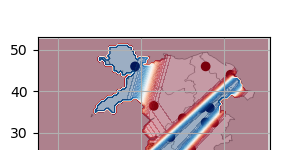

iteration  1
Accuracy is 0.5012497596616036
iteration  2
Accuracy is 0.5298980965199
iteration  3
Accuracy is 0.500865218227264
iteration  4
Accuracy is 0.5389348202268794
iteration  5
Accuracy is 0.5170159584695251
iteration  6
Accuracy is 0.5062487983080177
iteration  7
Accuracy is 0.5116323783887714
iteration  8
Accuracy is 0.5227840799846183
iteration  9
Accuracy is 0.5243222457219765
iteration  10
Accuracy is 0.5235531628532974
iteration  11
Accuracy is 0.5210536435300903
iteration  12
Accuracy is 0.5231686214189579
iteration  13
Accuracy is 0.5187463949240531
iteration  14
Accuracy is 0.5272063064795232
iteration  15
Accuracy is 0.5247067871563161
iteration  16
Accuracy is 0.5175927706210344
iteration  17
Accuracy is 0.5277831186310324
iteration  18
Accuracy is 0.5416266102672563
iteration  19
Accuracy is 0.5429725052874447
iteration  20
Accuracy is 0.5398961738127284
iteration  21
Accuracy is 0.5429725052874447
experiment:  4


<IPython.core.display.Javascript object>


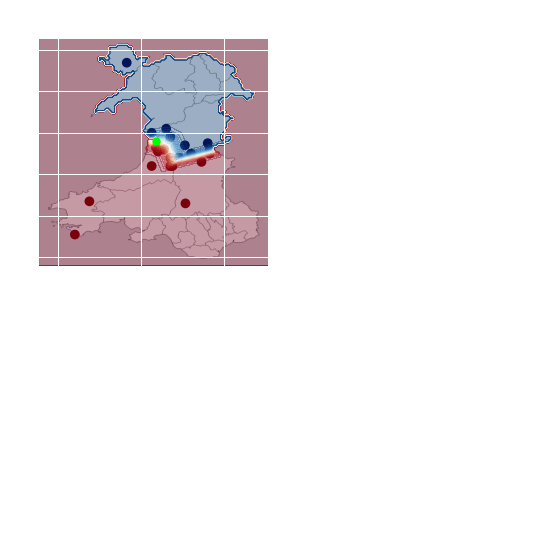

iteration  1
Accuracy is 0.5177850413382042
iteration  2
Accuracy is 0.48644491443953086
iteration  3
Accuracy is 0.48740626802537973
iteration  4
Accuracy is 0.4866371851567006
iteration  5
Accuracy is 0.48490674870217265
iteration  6
Accuracy is 0.49202076523745436
iteration  7
Accuracy is 0.4877908094597193
iteration  8
Accuracy is 0.48817535089405883
iteration  9
Accuracy is 0.4875985387425495
iteration  10
Accuracy is 0.49375120169198233
iteration  11
Accuracy is 0.49298211882330323
iteration  12
Accuracy is 0.4875985387425495
iteration  13
Accuracy is 0.4902903287829264
iteration  14
Accuracy is 0.4902903287829264
iteration  15
Accuracy is 0.48567583157085176
iteration  16
Accuracy is 0.4862526437223611
iteration  17
Accuracy is 0.4902903287829264
iteration  18
Accuracy is 0.4899057873485868
iteration  19
Accuracy is 0.4935589309748125
iteration  20
Accuracy is 0.48279177081330515
iteration  21
Accuracy is 0.4960584502980196
experiment:  5


<IPython.core.display.Javascript object>


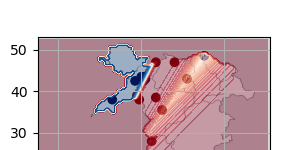

iteration  1
Accuracy is 0.47510094212651416
iteration  2
Accuracy is 0.48894443376273794
iteration  3
Accuracy is 0.48183041722745623
iteration  4
Accuracy is 0.5095174004999039
iteration  5
Accuracy is 0.5287444722168814
iteration  6
Accuracy is 0.5237454335704672
iteration  7
Accuracy is 0.5314362622572583
iteration  8
Accuracy is 0.5243222457219765
iteration  9
Accuracy is 0.5279753893482023
iteration  10
Accuracy is 0.5293212843683907
iteration  11
Accuracy is 0.5273985771966929
iteration  12
Accuracy is 0.5279753893482023
iteration  13
Accuracy is 0.5285522014997116
iteration  14
Accuracy is 0.5275908479138627
iteration  15
Accuracy is 0.5264372236108441
iteration  16
Accuracy is 0.5297058258027303
iteration  17
Accuracy is 0.5300903672370698
iteration  18
Accuracy is 0.5183618534897135
iteration  19
Accuracy is 0.5297058258027303
iteration  20
Accuracy is 0.5298980965199
iteration  21
Accuracy is 0.5285522014997116
experiment:  6


<IPython.core.display.Javascript object>


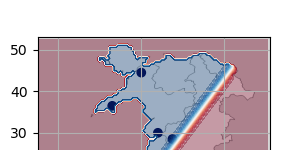

iteration  1
Accuracy is 0.5322053451259373
iteration  2
Accuracy is 0.50432609113632
iteration  3
Accuracy is 0.5012497596616036
iteration  4
Accuracy is 0.5033647375504711
iteration  5
Accuracy is 0.5016343010959431
iteration  6
Accuracy is 0.5302826379542396
iteration  7
Accuracy is 0.5281676600653721
iteration  8
Accuracy is 0.49817342818688715
iteration  9
Accuracy is 0.5093251297827341
iteration  10
Accuracy is 0.5260526821765045
iteration  11
Accuracy is 0.5348971351663142
iteration  12
Accuracy is 0.5250913285906557
iteration  13
Accuracy is 0.5308594501057489
iteration  14
Accuracy is 0.5370121130551817
iteration  15
Accuracy is 0.54701019034801
iteration  16
Accuracy is 0.5077869640453759
iteration  17
Accuracy is 0.5191309363583926
iteration  18
Accuracy is 0.535089405883484
iteration  19
Accuracy is 0.5183618534897135
iteration  20
Accuracy is 0.5218227263987695
iteration  21
Accuracy is 0.5306671793885791
experiment:  7


<IPython.core.display.Javascript object>


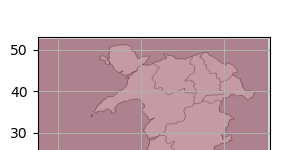

iteration  1
Accuracy is 0.46837146702557203
iteration  2
Accuracy is 0.4960584502980196
iteration  3
Accuracy is 0.45587387040953664
iteration  4
Accuracy is 0.4954816381465103
iteration  5
Accuracy is 0.4862526437223611
iteration  6
Accuracy is 0.49778888675254757
iteration  7
Accuracy is 0.491443953085945
iteration  8
Accuracy is 0.4939434724091521
iteration  9
Accuracy is 0.4972120746010383
iteration  10
Accuracy is 0.49701980388386846
iteration  11
Accuracy is 0.4952893674293405
iteration  12
Accuracy is 0.49701980388386846
iteration  13
Accuracy is 0.49663526244952894
iteration  14
Accuracy is 0.49894251105556625
iteration  15
Accuracy is 0.4983656989040569
iteration  16
Accuracy is 0.49778888675254757
iteration  17
Accuracy is 0.4975966160353778
iteration  18
Accuracy is 0.499134781772736
iteration  19
Accuracy is 0.4987502403383965
iteration  20
Accuracy is 0.4964429917323592
iteration  21
Accuracy is 0.4987502403383965
experiment:  8


<IPython.core.display.Javascript object>


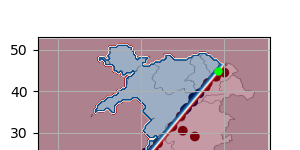

iteration  1
Accuracy is 0.5047106325706595
iteration  2
Accuracy is 0.5135550855604691
iteration  3
Accuracy is 0.5189386656412228
iteration  4
Accuracy is 0.517977312055374
iteration  5
Accuracy is 0.5147087098634878
iteration  6
Accuracy is 0.5125937319746202
iteration  7
Accuracy is 0.5156700634493366
iteration  8
Accuracy is 0.516246875600846
iteration  9
Accuracy is 0.516246875600846
iteration  10
Accuracy is 0.517977312055374
iteration  11
Accuracy is 0.5166314170351856
iteration  12
Accuracy is 0.5160546048836763
iteration  13
Accuracy is 0.5164391463180158
iteration  14
Accuracy is 0.5170159584695251
iteration  15
Accuracy is 0.5168236877523553
iteration  16
Accuracy is 0.5170159584695251
iteration  17
Accuracy is 0.5175927706210344
iteration  18
Accuracy is 0.5175927706210344
iteration  19
Accuracy is 0.5172082291866948
iteration  20
Accuracy is 0.5172082291866948
iteration  21
Accuracy is 0.5170159584695251
experiment:  9


<IPython.core.display.Javascript object>


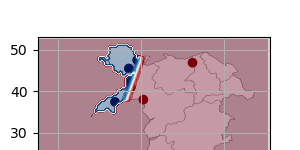

iteration  1
Accuracy is 0.5331666987117862
iteration  2
Accuracy is 0.5268217650451836
iteration  3
Accuracy is 0.5237454335704672
iteration  4
Accuracy is 0.5270140357623534
iteration  5
Accuracy is 0.5266294943280139
iteration  6
Accuracy is 0.523937704287637
iteration  7
Accuracy is 0.5241299750048067
iteration  8
Accuracy is 0.5248990578734859
iteration  9
Accuracy is 0.5248990578734859
iteration  10
Accuracy is 0.5260526821765045
iteration  11
Accuracy is 0.5264372236108441
iteration  12
Accuracy is 0.5304749086714093
iteration  13
Accuracy is 0.5291290136512209
iteration  14
Accuracy is 0.5302826379542396
iteration  15
Accuracy is 0.5289367429340511
iteration  16
Accuracy is 0.5268217650451836
iteration  17
Accuracy is 0.5289367429340511
iteration  18
Accuracy is 0.5291290136512209
iteration  19
Accuracy is 0.5297058258027303
iteration  20
Accuracy is 0.5258604114593347
iteration  21
Accuracy is 0.5306671793885791
experiment:  10


<IPython.core.display.Javascript object>


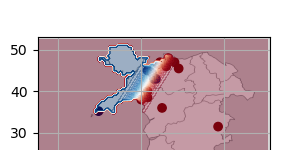

iteration  1
Accuracy is 0.4843299365506633
iteration  2
Accuracy is 0.5147087098634878
iteration  3
Accuracy is 0.5283599307825418
iteration  4
Accuracy is 0.5320130744087676
iteration  5
Accuracy is 0.5216304556815997
iteration  6
Accuracy is 0.5272063064795232
iteration  7
Accuracy is 0.5293212843683907
iteration  8
Accuracy is 0.5300903672370698
iteration  9
Accuracy is 0.5302826379542396
iteration  10
Accuracy is 0.5295135550855604
iteration  11
Accuracy is 0.5295135550855604
iteration  12
Accuracy is 0.5283599307825418
iteration  13
Accuracy is 0.5291290136512209
iteration  14
Accuracy is 0.5291290136512209
iteration  15
Accuracy is 0.5291290136512209
iteration  16
Accuracy is 0.5291290136512209
iteration  17
Accuracy is 0.5291290136512209
iteration  18
Accuracy is 0.5295135550855604
iteration  19
Accuracy is 0.5293212843683907
iteration  20
Accuracy is 0.5281676600653721
iteration  21
Accuracy is 0.5293212843683907
experiment:  11


<IPython.core.display.Javascript object>


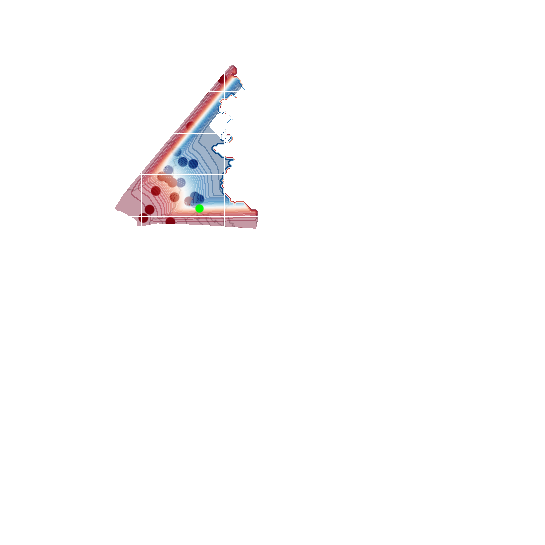

iteration  1
Accuracy is 0.49778888675254757
iteration  2
Accuracy is 0.49009805806575657
iteration  3
Accuracy is 0.4983656989040569
iteration  4
Accuracy is 0.4810613343587772
iteration  5
Accuracy is 0.47875408575273987
iteration  6
Accuracy is 0.48279177081330515
iteration  7
Accuracy is 0.48932897519707746
iteration  8
Accuracy is 0.4814458757931167
iteration  9
Accuracy is 0.4850990194193424
iteration  10
Accuracy is 0.4927898481061334
iteration  11
Accuracy is 0.4972120746010383
iteration  12
Accuracy is 0.5020188425302826
iteration  13
Accuracy is 0.5002884060757546
iteration  14
Accuracy is 0.5016343010959431
iteration  15
Accuracy is 0.49202076523745436
iteration  16
Accuracy is 0.49855796962122667
iteration  17
Accuracy is 0.4960584502980196
iteration  18
Accuracy is 0.49971159392424536
iteration  19
Accuracy is 0.4999038646414151
iteration  20
Accuracy is 0.5047106325706595
iteration  21
Accuracy is 0.4993270524899058
experiment:  12


<IPython.core.display.Javascript object>


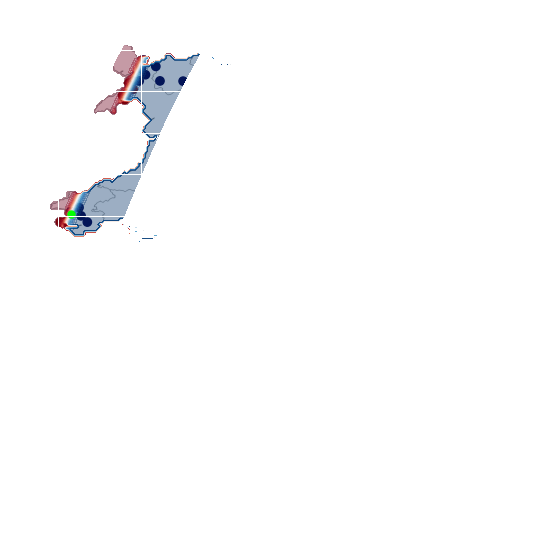

iteration  1
Accuracy is 0.47317823495481637
iteration  2
Accuracy is 0.4676023841568929
iteration  3
Accuracy is 0.46837146702557203
iteration  4
Accuracy is 0.471832339934628
iteration  5
Accuracy is 0.47106325706594887
iteration  6
Accuracy is 0.47279369352047684
iteration  7
Accuracy is 0.4722168813689675
iteration  8
Accuracy is 0.4739473178234955
iteration  9
Accuracy is 0.47510094212651416
iteration  10
Accuracy is 0.47644683714670255
iteration  11
Accuracy is 0.47952316862141897
iteration  12
Accuracy is 0.47644683714670255
iteration  13
Accuracy is 0.4758700249951932
iteration  14
Accuracy is 0.4785618150355701
iteration  15
Accuracy is 0.4770236492982119
iteration  16
Accuracy is 0.47644683714670255
iteration  17
Accuracy is 0.4762545664295328
iteration  18
Accuracy is 0.47490867140934434
iteration  19
Accuracy is 0.47510094212651416
iteration  20
Accuracy is 0.47510094212651416
iteration  21
Accuracy is 0.4762545664295328
experiment:  13


<IPython.core.display.Javascript object>


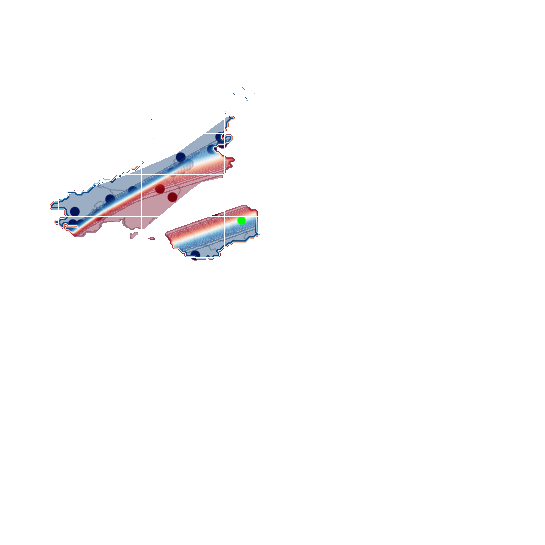

iteration  1
Accuracy is 0.5006729475100942
iteration  2
Accuracy is 0.5020188425302826
iteration  3
Accuracy is 0.5016343010959431
iteration  4
Accuracy is 0.5018265718131129
iteration  5
Accuracy is 0.49567390886368007
iteration  6
Accuracy is 0.4983656989040569
iteration  7
Accuracy is 0.4964429917323592
iteration  8
Accuracy is 0.4972120746010383
iteration  9
Accuracy is 0.500865218227264
iteration  10
Accuracy is 0.49701980388386846
iteration  11
Accuracy is 0.49951932320707554
iteration  12
Accuracy is 0.49894251105556625
iteration  13
Accuracy is 0.49951932320707554
iteration  14
Accuracy is 0.49951932320707554
iteration  15
Accuracy is 0.49855796962122667
iteration  16
Accuracy is 0.49894251105556625
iteration  17
Accuracy is 0.5000961353585849
iteration  18
Accuracy is 0.5004806767929244
iteration  19
Accuracy is 0.4993270524899058
iteration  20
Accuracy is 0.49567390886368007
iteration  21
Accuracy is 0.4879830801768891
experiment:  14


<IPython.core.display.Javascript object>


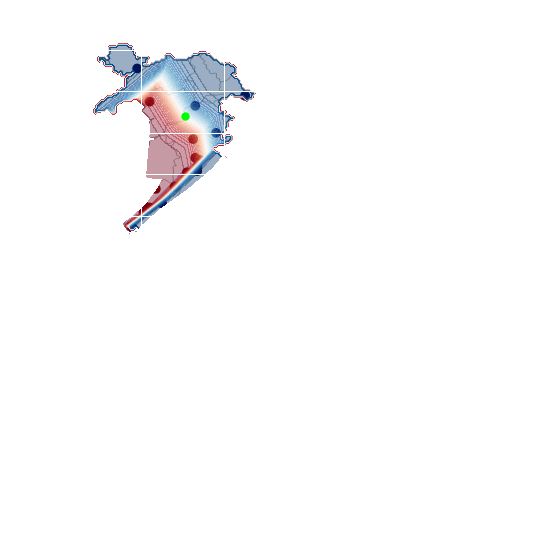

iteration  1
Accuracy is 0.46260334551047877
iteration  2
Accuracy is 0.4662564891367045
iteration  3
Accuracy is 0.49778888675254757
iteration  4
Accuracy is 0.49817342818688715
iteration  5
Accuracy is 0.4968275331666987
iteration  6
Accuracy is 0.4947125552778312
iteration  7
Accuracy is 0.5000961353585849
iteration  8
Accuracy is 0.49202076523745436
iteration  9
Accuracy is 0.49413574312632186
iteration  10
Accuracy is 0.49336666025764275
iteration  11
Accuracy is 0.49413574312632186
iteration  12
Accuracy is 0.4943280138434916
iteration  13
Accuracy is 0.49452028456066144
iteration  14
Accuracy is 0.49336666025764275
iteration  15
Accuracy is 0.48721399730820997
iteration  16
Accuracy is 0.46837146702557203
iteration  17
Accuracy is 0.4576043068640646
iteration  18
Accuracy is 0.47164006921745816
iteration  19
Accuracy is 0.458950201884253
iteration  20
Accuracy is 0.4862526437223611
iteration  21
Accuracy is 0.5100942126514132
experiment:  15


<IPython.core.display.Javascript object>


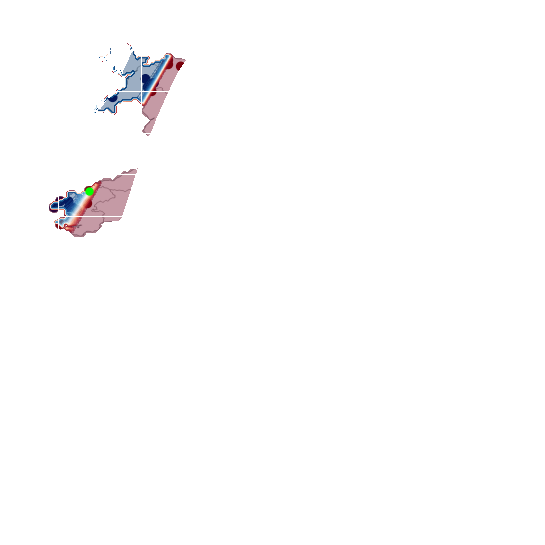

iteration  1
Accuracy is 0.5041338204191501
iteration  2
Accuracy is 0.5283599307825418
iteration  3
Accuracy is 0.5306671793885791
iteration  4
Accuracy is 0.5250913285906557
iteration  5
Accuracy is 0.5277831186310324
iteration  6
Accuracy is 0.5298980965199
iteration  7
Accuracy is 0.5281676600653721
iteration  8
Accuracy is 0.5297058258027303
iteration  9
Accuracy is 0.5302826379542396
iteration  10
Accuracy is 0.5300903672370698
iteration  11
Accuracy is 0.5308594501057489
iteration  12
Accuracy is 0.5306671793885791
iteration  13
Accuracy is 0.5314362622572583
iteration  14
Accuracy is 0.5335512401461258
iteration  15
Accuracy is 0.5298980965199
iteration  16
Accuracy is 0.5323976158431071
iteration  17
Accuracy is 0.5308594501057489
iteration  18
Accuracy is 0.5312439915400884
iteration  19
Accuracy is 0.5312439915400884
iteration  20
Accuracy is 0.5318208036915978
iteration  21
Accuracy is 0.5306671793885791
experiment:  16


<IPython.core.display.Javascript object>


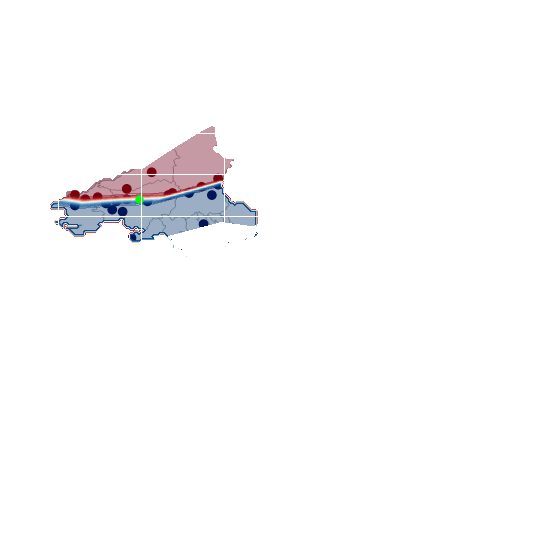

iteration  1
Accuracy is 0.5145164391463181
iteration  2
Accuracy is 0.49701980388386846
iteration  3
Accuracy is 0.5083637761968852
iteration  4
Accuracy is 0.5127860026917901
iteration  5
Accuracy is 0.508556046914055
iteration  6
Accuracy is 0.5139396269948087
iteration  7
Accuracy is 0.5072101518938665
iteration  8
Accuracy is 0.5114401076716016
iteration  9
Accuracy is 0.5147087098634878
iteration  10
Accuracy is 0.5056719861565083
iteration  11
Accuracy is 0.5093251297827341
iteration  12
Accuracy is 0.5143241684291482
iteration  13
Accuracy is 0.5164391463180158
iteration  14
Accuracy is 0.5195154777927322
iteration  15
Accuracy is 0.5208613728129206
iteration  16
Accuracy is 0.5191309363583926
iteration  17
Accuracy is 0.5187463949240531
iteration  18
Accuracy is 0.5187463949240531
iteration  19
Accuracy is 0.5189386656412228
iteration  20
Accuracy is 0.5187463949240531
iteration  21
Accuracy is 0.5216304556815997
experiment:  17


<IPython.core.display.Javascript object>


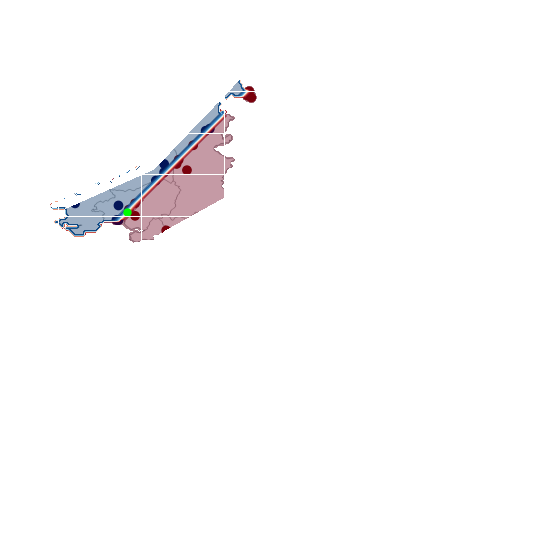

iteration  1
Accuracy is 0.5483560853681985
iteration  2
Accuracy is 0.5018265718131129
iteration  3
Accuracy is 0.5020188425302826
iteration  4
Accuracy is 0.4960584502980196
iteration  5
Accuracy is 0.5024033839646221
iteration  6
Accuracy is 0.506056527590848
iteration  7
Accuracy is 0.5099019419342434
iteration  8
Accuracy is 0.5072101518938665
iteration  9
Accuracy is 0.5081715054797155
iteration  10
Accuracy is 0.508556046914055
iteration  11
Accuracy is 0.5095174004999039
iteration  12
Accuracy is 0.5072101518938665
iteration  13
Accuracy is 0.5079792347625457
iteration  14
Accuracy is 0.5074024226110363
iteration  15
Accuracy is 0.5083637761968852
iteration  16
Accuracy is 0.5087483176312247
iteration  17
Accuracy is 0.5091328590655643
iteration  18
Accuracy is 0.5093251297827341
iteration  19
Accuracy is 0.5097096712170737
iteration  20
Accuracy is 0.5093251297827341
iteration  21
Accuracy is 0.510286483368583
experiment:  18


<IPython.core.display.Javascript object>


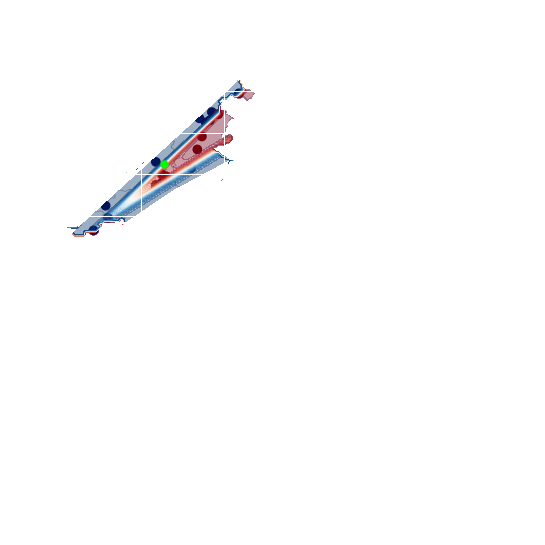

iteration  1
Accuracy is 0.5135550855604691
iteration  2
Accuracy is 0.535089405883484
iteration  3
Accuracy is 0.5031724668333013
iteration  4
Accuracy is 0.5072101518938665
iteration  5
Accuracy is 0.5404729859642377
iteration  6
Accuracy is 0.5075946933282061
iteration  7
Accuracy is 0.5029801961161315
iteration  8
Accuracy is 0.5000961353585849
iteration  9
Accuracy is 0.5031724668333013
iteration  10
Accuracy is 0.5029801961161315
iteration  11
Accuracy is 0.5022111132474524
iteration  12
Accuracy is 0.5027879253989618
iteration  13
Accuracy is 0.5024033839646221
iteration  14
Accuracy is 0.5049029032878293
iteration  15
Accuracy is 0.5031724668333013
iteration  16
Accuracy is 0.506056527590848
iteration  17
Accuracy is 0.502595654681792
iteration  18
Accuracy is 0.505095174004999
iteration  19
Accuracy is 0.5041338204191501
iteration  20
Accuracy is 0.5047106325706595
iteration  21
Accuracy is 0.5039415497019804
experiment:  19


<IPython.core.display.Javascript object>


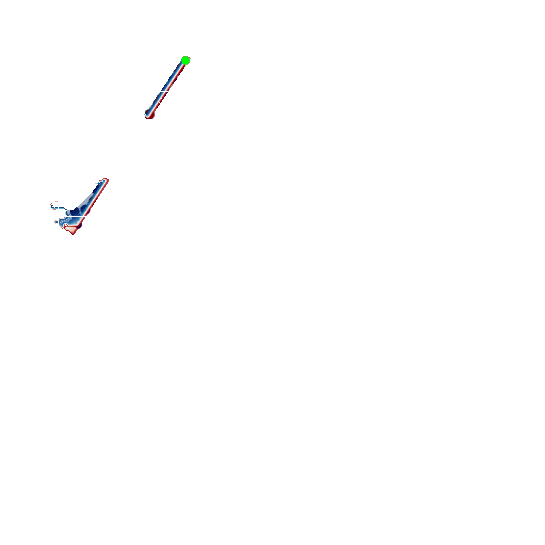

iteration  1
Accuracy is 0.5283599307825418
iteration  2
Accuracy is 0.5225918092674485
iteration  3
Accuracy is 0.523937704287637
iteration  4
Accuracy is 0.5202845606614113
iteration  5
Accuracy is 0.5195154777927322
iteration  6
Accuracy is 0.5220149971159392
iteration  7
Accuracy is 0.5223995385502788
iteration  8
Accuracy is 0.5235531628532974
iteration  9
Accuracy is 0.523937704287637
iteration  10
Accuracy is 0.5250913285906557
iteration  11
Accuracy is 0.525668140742165
iteration  12
Accuracy is 0.5258604114593347
iteration  13
Accuracy is 0.525668140742165
iteration  14
Accuracy is 0.5264372236108441
iteration  15
Accuracy is 0.5275908479138627
iteration  16
Accuracy is 0.5277831186310324
iteration  17
Accuracy is 0.5277831186310324
iteration  18
Accuracy is 0.5272063064795232
iteration  19
Accuracy is 0.5291290136512209
iteration  20
Accuracy is 0.5287444722168814
iteration  21
Accuracy is 0.5285522014997116
experiment:  20


<IPython.core.display.Javascript object>


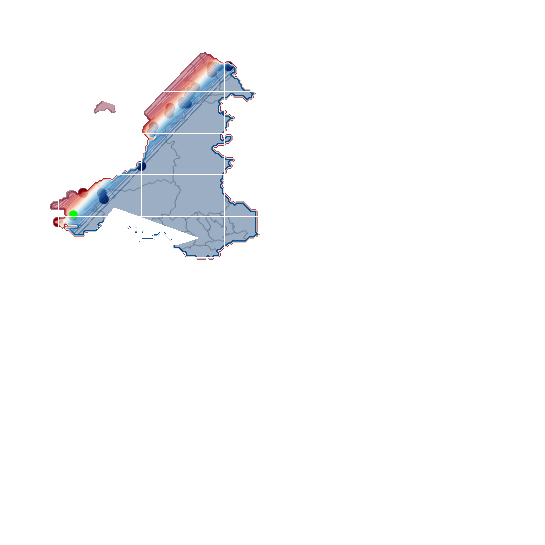

iteration  1
Accuracy is 0.5127860026917901
iteration  2
Accuracy is 0.4839453951163238
iteration  3
Accuracy is 0.48009998077292826
iteration  4
Accuracy is 0.48163814651028647
iteration  5
Accuracy is 0.4839453951163238
iteration  6
Accuracy is 0.49009805806575657
iteration  7
Accuracy is 0.4877908094597193
iteration  8
Accuracy is 0.48644491443953086
iteration  9
Accuracy is 0.4899057873485868
iteration  10
Accuracy is 0.4902903287829264
iteration  11
Accuracy is 0.49009805806575657
iteration  12
Accuracy is 0.4891367044799077
iteration  13
Accuracy is 0.4877908094597193
iteration  14
Accuracy is 0.48932897519707746
iteration  15
Accuracy is 0.49125168236877526
iteration  16
Accuracy is 0.49259757738896365
iteration  17
Accuracy is 0.49567390886368007
iteration  18
Accuracy is 0.4891367044799077
iteration  19
Accuracy is 0.48971351663141705
iteration  20
Accuracy is 0.4922130359546241
iteration  21
Accuracy is 0.48721399730820997


In [7]:
from random import randint
import time

valid_seeds = [12,15,17,21,23,24,25,31,35,36,37,41,43,45,49,52,55,56,57,58,59]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            eggholderColor(landpoints[value],threshold_low,threshold_high)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], eggholderColor(nextpoint,threshold_low,threshold_high)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 51.28 %
Improvement is = 0.00 %


In [9]:
Results

[[0.50432609113632,
  0.5062487983080177,
  0.5056719861565083,
  0.5093251297827341,
  0.5247067871563161,
  0.5112478369544319,
  0.506825610459527,
  0.5181695827725438,
  0.5052874447221688,
  0.5089405883483945,
  0.5100942126514132,
  0.5145164391463181,
  0.5152855220149971,
  0.5154777927321669,
  0.5143241684291482,
  0.5135550855604691,
  0.5152855220149971,
  0.5185541242068833,
  0.517977312055374,
  0.517977312055374,
  0.5210536435300903],
 [0.5366275716208422,
  0.549509709671217,
  0.5331666987117862,
  0.5356662180349933,
  0.5420111517015959,
  0.534128052297635,
  0.5373966544895212,
  0.534128052297635,
  0.5304749086714093,
  0.5379734666410305,
  0.5412420688329167,
  0.5464333781965006,
  0.5389348202268794,
  0.5397039030955586,
  0.5420111517015959,
  0.5448952124591425,
  0.5379734666410305,
  0.5441261295904634,
  0.5420111517015959,
  0.54701019034801,
  0.5464333781965006],
 [0.4964429917323592,
  0.49413574312632186,
  0.48259950009613534,
  0.524322245721

In [12]:
np.savetxt('eggholder05nn', Results)

In [13]:
tst = np.loadtxt('eggholder05nn')